## Image classification

> Akshay Bankar (2019201011)

### Convolution Neural Networks

A CNN has


> Convolutional layers : The Convolutional layer takes the input image and applies m number of nxn filters to receive a feature map.

> Activation function layers : activation function is applied onto the feature maps to increase non-linearity in the network. This is because images themselves are highly non-linear. Convolution is a linear operation with things like element wise matrix multiplication and addition. The real-world data we want our CNN to learn will be non-linear. We can account for that with some non-linear operation performed on feature maps.

> Pooling layers : The pooling layer is essentially used for dimensionality reduction, it picks only the best features from the feature map.

> Fully connected layer : All the features are flattened and sent as input to the fully connected dense neural network which learns the weights using backpropagation and provides the classification output.


### Classifying images from CIFAR100 dataset using PyTorch

The CIFAR10 dataset consists of 50,000 training images and 10,000 test images of size 32 x 32.

torch.nn package : Models are defined in PyTorch by custom classes that extend the Module class. All the components of the models can be found in the torch.nn package
torchvision package : The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision. We use this to load CIFAR100 dataset and to perform transformation on the images. 

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from PIL import Image



> Define a mini-network consisting of Convolution-Batchnormalization-Activation.

nn.Conv2d() : The function defines aa convolution layer which takes arguments as number of input channels, number of output channels which corresponds to feature detectors and kernel size.


nn.BatchNorm2d() : Batch Normalization normalizes all inputs to have zero mean and unit variance.

Activation layer : Applies non-linearity to the output of convolution layer depending on the parameter supplied.



In [11]:
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels, activation = 'relu'):
        super(Unit, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, kernel_size=3, out_channels=out_channels, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output



> Using the above defined basic unit, define a neural network model as stack of Convolution-Activation-Pooling layers.



In [29]:
class Net(nn.Module):
    def __init__(self,num_classes=100):
        super(Net,self).__init__()

        #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.unit2 = Unit(in_channels=32, out_channels=64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.unit3 = Unit(in_channels=64, out_channels=128)
        self.pool3 = nn.AvgPool2d(kernel_size=8)
        '''
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
                                 self.unit12, self.unit13, self.unit14, self.avgpool)
        '''
        self.net = nn.Sequential(self.unit1, self.pool1, self.unit2, self.pool2, self.unit3, self.pool3)
        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128) ####### 128
        output = self.fc(output)
        return output

Packages :

torch.optim package : Implements various optimization algorithms like Adam, SGD etc.

torch.utils.data : PyTorch data loading utility is the torch.utils.data.DataLoader class. It represents a Python iterable over a dataset.

torch.autograd : provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions.

In [13]:
from torchvision.datasets import CIFAR100
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable

> Data pre-processing : This helps the model to classify images properly irrespective of the perspective from which it is displayed.

Transformations : RandomHorizontalFlip randomly flips the images horizontally. RandomCrop randomly crops the image.

ToTensor converts the images into a format usable by PyTorch. Normalize with the values given below would make all our pixels range between -1 to +1

In [14]:
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Define transformations for the test set
test_transformations = transforms.Compose([
   transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

])



> Download and create a loader for training and testing set



In [15]:
batch_size = 32

#Load the training set
train_set = CIFAR100(root="./data",train=True,transform=train_transformations,download=True)

#Create a loder for the training set
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)

#Load the test set, note that train is set to False
test_set = CIFAR100(root="./data",train=False,transform=test_transformations,download=True)

#Create a loder for the test set, note that both shuffle is set to false for the test loader
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=4)

cuda_avail = torch.cuda.is_available()

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified




> Create model, use Adam optimizer, cross entropy loss as loss function.



In [30]:
#Create model, optimizer and loss function
model = Net(num_classes=100)
if cuda_avail:
    model.cuda()
optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()



> Define function to train the model



In [31]:
def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            #Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
            #print(labels.data)
            #Clear all accumulated gradients
            optimizer.zero_grad()
            #Predict classes using images from the test set
            #print(images.shape)
            outputs = model(images)
            #Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs,labels)
            #Backpropagate the loss
            loss.backward()

            #Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            #print(torch.sum(prediction == labels.data))
            train_acc += torch.sum(prediction == labels.data)

        #Call the learning rate adjustment function
        #adjust_learning_rate(epoch)

        #Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / 50000
        train_loss = train_loss / 50000

        #Evaluate on the test set
        test_acc = test()

        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
            #save_models(epoch)
            best_acc = test_acc


        # Print the metrics
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))




> Define function to test the model



In [32]:
def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):
      
        if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

        #Predict classes using images from the test set
        outputs = model(images)
        _,prediction = torch.max(outputs.data, 1)
        #prediction = prediction.cpu().numpy()
        test_acc += torch.sum(prediction == labels.data)
        


    #Compute the average acc and loss over all 10000 test images
    test_acc = test_acc / 10000

    return test_acc

In [33]:
if __name__ == "__main__":
    train(20)

Epoch 0, Train Accuracy: 0.13023999333381653 , TrainLoss: 3.722087860107422 , Test Accuracy: 0.19449999928474426
Epoch 1, Train Accuracy: 0.22336000204086304 , TrainLoss: 3.1618690490722656 , Test Accuracy: 0.2517000138759613


KeyboardInterrupt: 

In [19]:
#Import needed packages
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR100
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np


class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class SimpleNet(nn.Module):
    def __init__(self,num_classes=100):
        super(SimpleNet,self).__init__()

        #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.unit2 = Unit(in_channels=32, out_channels=64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.unit3 = Unit(in_channels=64, out_channels=128)
        self.pool3 = nn.MaxPool2d(kernel_size=8)
        '''
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
                                 self.unit12, self.unit13, self.unit14, self.avgpool)
        '''
        self.net = nn.Sequential(self.unit1, self.pool1, self.unit2, self.pool2, self.unit3, self.pool3)
        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)
        return output

#Define transformations for the training set, flip the images randomly, crop out and apply mean and std normalization
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

#Load the training set
train_set = CIFAR100(root="./content/drive/My Drive/computer_vision/assignments/assignment_4/data",train=True,transform=train_transformations,download=True)

#Create a loder for the training set
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)


#Define transformations for the test set
test_transformations = transforms.Compose([
   transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

])

#Load the test set, note that train is set to False
test_set = CIFAR100(root="./content/drive/My Drive/computer_vision/assignments/assignment_4/data",train=False,transform=test_transformations,download=True)

#Create a loder for the test set, note that both shuffle is set to false for the test loader
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=4)

#Check if gpu support is available
cuda_avail = torch.cuda.is_available()

#Create model, optimizer and loss function
model = SimpleNet(num_classes=100)

if cuda_avail:
    model.cuda()

optimizer = Adam(model.parameters(), lr=0.01,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

#Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):

    lr = 0.001

    if epoch > 180:
        lr = lr / 1000000
    elif epoch > 150:
        lr = lr / 100000
    elif epoch > 120:
        lr = lr / 10000
    elif epoch > 90:
        lr = lr / 1000
    elif epoch > 60:
        lr = lr / 100
    elif epoch > 30:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr




def save_models(epoch):
    torch.save(model.state_dict(), "cifar10model_{}.model".format(epoch))
    print("Checkpoint saved")

def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):
      
        if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

        #Predict classes using images from the test set
        outputs = model(images)
        _,prediction = torch.max(outputs.data, 1)
        #prediction = prediction.cpu().numpy()
        test_acc += torch.sum(prediction == labels.data)
        


    #Compute the average acc and loss over all 10000 test images
    test_acc = test_acc / 10000

    return test_acc

def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            #Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            #Clear all accumulated gradients
            optimizer.zero_grad()
            #Predict classes using images from the test set
            outputs = model(images)
            #Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs,labels)
            #Backpropagate the loss
            loss.backward()

            #Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc += torch.sum(prediction == labels.data)

        #Call the learning rate adjustment function
        adjust_learning_rate(epoch)

        #Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / 50000
        train_loss = train_loss / 50000

        #Evaluate on the test set
        test_acc = test()

        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc


        # Print the metrics
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))


if __name__ == "__main__":
    train(20)

KeyboardInterrupt: 

In [23]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('./runs/fashion_mnist_experiment_1')

ImportError: TensorBoard logging requires TensorBoard with Python summary writer installed. This should be available in 1.14 or above.

NameError: name 'writer' is not defined

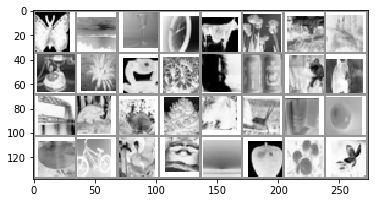

In [21]:
import matplotlib.pyplot as plt
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [22]:
!tensorboard --logdir=runs 

/bin/sh: 1: tensorboard: not found
